**From Image-text matching**  
มันสามารถทำ Image Captioning ได้ด้วย BLIP

In [1]:
# !pip install transformers torch pillow

In [2]:
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
!wget https://www.vets4pets.com/siteassets/species/cat/two-cats-on-wall-in-sun.jpg -O cats.jpg
!wget https://www.worldanimalprotection.ca/cdn-cgi/image/width=1280,format=auto/siteassets/shutterstock_481623085.jpg -O cows.jpg
!wget https://supertails.com/cdn/shop/articles/1c3a0644-1ffb-4641-b2ea-5483b4ada874_520x500_a001116b-8f20-4bef-8b4c-2a57a1882223.webp?v=1734423067 -O dogs.jpg

--2025-10-07 05:06:56--  https://www.vets4pets.com/siteassets/species/cat/two-cats-on-wall-in-sun.jpg
Resolving www.vets4pets.com (www.vets4pets.com)... 172.64.145.64, 104.18.42.192, 2a06:98c1:310b::6812:2ac0, ...
Connecting to www.vets4pets.com (www.vets4pets.com)|172.64.145.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444966 (435K) [image/jpeg]
Saving to: ‘cats.jpg’

cats.jpg            100%[===================>] 434.54K  --.-KB/s    in 0.02s   

2025-10-07 05:06:57 (18.0 MB/s) - ‘cats.jpg’ saved [444966/444966]

--2025-10-07 05:06:57--  https://www.worldanimalprotection.ca/cdn-cgi/image/width=1280,format=auto/siteassets/shutterstock_481623085.jpg
Resolving www.worldanimalprotection.ca (www.worldanimalprotection.ca)... 104.18.42.31, 172.64.145.225, 2a06:98c1:310d::6812:2a1f, ...
Connecting to www.worldanimalprotection.ca (www.worldanimalprotection.ca)|104.18.42.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115127 (112K) [

In [4]:
# Load model directly
from transformers import AutoProcessor, AutoModelForVision2Seq

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model_captioning = AutoModelForVision2Seq.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2242: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

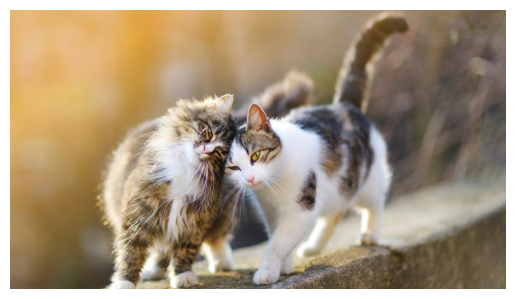

In [5]:
image = Image.open('cats.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
text = 'An image of ' # บริบทของ model เพื่อให้ model generate คำบรรยาย
inputs = processor(images=image, text=text, return_tensors='pt')

In [20]:
output = model_captioning.generate(**inputs)

In [24]:
print(output)

tensor([[30522,  2019,  3746,  1997,  1037,  4937,  3788,  2006,  1037,  2813,
           102]])


In [27]:
# แปลง token ออกมาเป็นข้อความ
out_text = processor.decode(output[0], skip_special_tokens=True)
# skip_special_tokens สั่งไม่ให้แสดง token พิเศษเช่นอักขระ บอกจุดเริ่มต้นจุดจบของประโยค


In [39]:
print(out_text)

an image of a cat walking on a wall


In [28]:
# use Image text matching to validate result from image captionning model
# Load model directly
from transformers import AutoProcessor, BlipForImageTextRetrieval

processor = AutoProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
image_text_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/895M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/895M [00:00<?, ?B/s]

In [30]:
inputs_itm = processor(images=image, text=out_text, return_tensors='pt')
output_itm = image_text_model(**inputs_itm)

In [31]:
itm_score = output_itm['itm_score']

In [32]:
itm_score

tensor([[-0.7928,  0.7926]], grad_fn=<AddmmBackward0>)

In [41]:
import torch

def get_probability(itm_score):
  probability_check = torch.nn.functional.softmax(itm_score, dim=1)
  return probability_check

In [42]:
probability_check = get_probability(itm_score)
print(probability_check)
print("Probability: ", round(probability_check[0][1].item(), 4))

tensor([[0.1700, 0.8300]], grad_fn=<SoftmaxBackward0>)
Probability:  0.83


**Unorditional Captioning**  
เป็นการไม่มอบเงื่อนไขหรือข้อความให้ model เลยให้เพียงแค่ภาพ ให้ model บรรยายอย่างเดียว

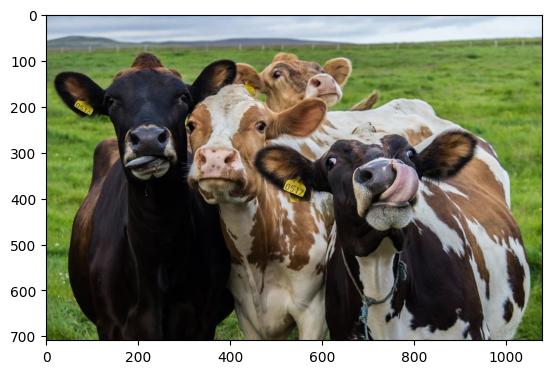

In [47]:
image = Image.open('cows.jpg')
plt.imshow(image)
plt.show()

In [48]:
inputs = processor(images=image, text="", return_tensors='pt')
output = model_captioning.generate(**inputs)

In [49]:
output_text = processor.decode(output[0], skip_special_tokens=True)
print(output_text)

a group of cows standing in a field


In [50]:
itm_input = processor(images=image, text=output_text, return_tensors='pt')
output_itm = image_text_model(**itm_input)

In [52]:
print(output_itm['itm_score'])

tensor([[-0.5152,  0.5166]], grad_fn=<AddmmBackward0>)


In [60]:
probability = get_probability(output_itm['itm_score'])
print("Probability: ", round(probability[0][1].item(),2))

Probability:  0.74
